In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from braindecode.models import EEGInceptionMI
from dataloader import dataloader

X_train, y_train, X_test, y_test = dataloader(1)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=16,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=16,
    shuffle=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EEGInceptionMI(
    n_chans=22,
    n_outputs=4,
    n_times=1001,
    sfreq=250,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 50

In [3]:
for epoch in range(n_epochs):
    model.train()
    train_loss = 0

    for Xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        Xb = Xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {train_loss:.3f}")

Epoch 1/50:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/50:  17%|█▋        | 3/18 [01:19<06:36, 26.43s/it]


KeyboardInterrupt: 

In [1]:
from data_augment import GaussianNoise, HundredHzNoise
import torch
from dataloader import dataloader

X_train, y_train, X_test, y_test = dataloader(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

freq_augm = HundredHzNoise(X_train).to(device)
print(freq_augm.relative_scale)
gaus_augm = GaussianNoise(relative_scale=freq_augm.relative_scale).to(device)

X_train : (288, 22, 1875)
y_train : (288,)
X_test  : (288, 22, 1875)
y_test  : (288,)
tensor([0.0989, 0.1178, 0.1086, 0.1043, 0.1083, 0.1168, 0.1635, 0.1302, 0.1178,
        0.1113, 0.1132, 0.1240, 0.1532, 0.1313, 0.1203, 0.1165, 0.1170, 0.1248,
        0.1254, 0.1212, 0.1236, 0.1281])


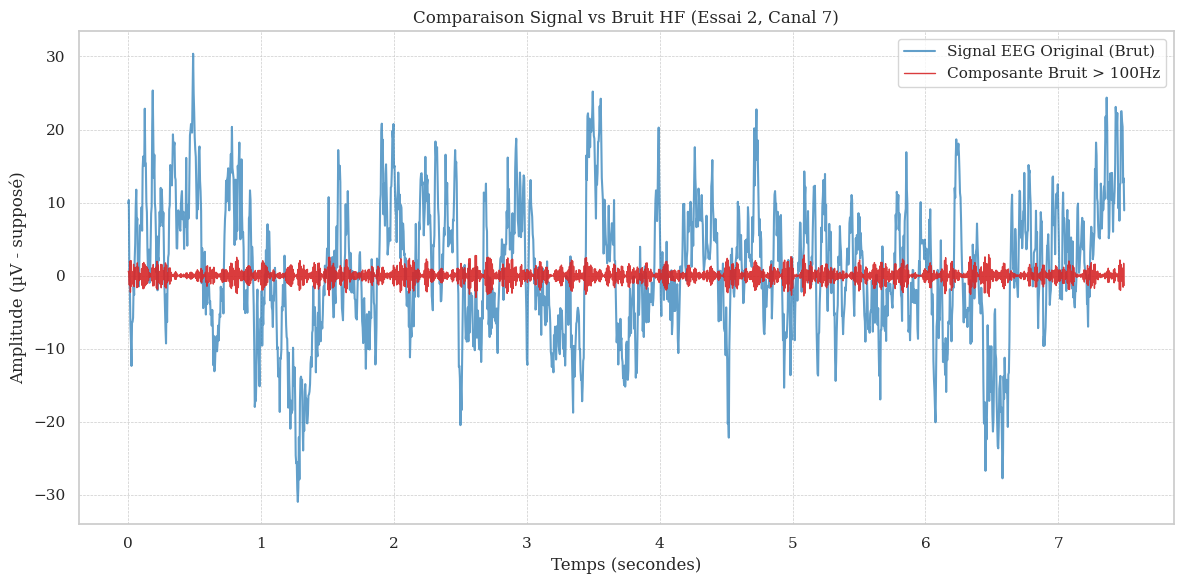

In [11]:
import matplotlib.pyplot as plt
fs = 250
cutoff = 100
trial_idx = 2
channel_idx = 7
original_signal = X_train[trial_idx, channel_idx, :]
noise_signal = freq_augm.noise_bank[trial_idx, channel_idx, :].cpu()

n_times = len(original_signal)
time_axis = np.arange(n_times) / fs

plt.figure(figsize=(12, 6))

# Plot 1 : Le signal original complet
# Alpha=0.7 pour le rendre légèrement transparent
plt.plot(time_axis, original_signal, label='Signal EEG Original (Brut)', 
         color='#1f77b4', linewidth=1.5, alpha=0.7)

# Plot 2 : Le bruit >100Hz extrait
# En rouge vif, légèrement plus fin pour voir les détails
plt.plot(time_axis, noise_signal, label=f'Composante Bruit > {cutoff}Hz', 
         color='#d62728', linewidth=1, alpha=0.9)

# Décoration
plt.title(f"Comparaison Signal vs Bruit HF (Essai {trial_idx}, Canal {channel_idx})")
plt.xlabel("Temps (secondes)")
plt.ylabel("Amplitude (µV - supposé)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()